# Sediment concentration at the boundaries

What is the sediment concentration at the river inflow and outflow? When has this reached a balance?

## Delta visualisation

What does the delta look like and what cross-sections are we looking at?

In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import dfm_tools as dfmt
from interactive import *

trim500 = "Mahakam_500/Mahakam/Mahakam_delta_Netcdf/trim-001.nc"
trih500 = "Mahakam_500/Mahakam/Mahakam_delta_Netcdf/trih-001.nc"

In [11]:
# What sediment data are we using?
h_data = nc.Dataset(trih500, mode='r')# Print metadata and variables
print(h_data.variables.keys())  # Lists all variable names
h_data.variables['SBTR']

dict_keys(['MNTRA', 'XYTRA', 'NAMTRA', 'SIG_LYR', 'SIG_INTF', 'KMAXOUT', 'KMAXOUT_RESTR', 'time', 'FLTR', 'CTR', 'ATR', 'DTR', 'MORFAC', 'MORFT', 'SBTR', 'SSTR', 'SBTRC', 'SSTRC'])


<class 'netCDF4.Variable'>
float32 SBTR(time, LSEDTOT, NTRUV)
    long_name: Instantaneous bed load transport through section
    units: m3/s
    coordinates: NAMTRA
unlimited dimensions: time
current shape = (78913, 1, 17)
filling on, default _FillValue of 9.969209968386869e+36 used

Your model was run with a D-FlowFM version from before 28-10-2020 (FLOW2D3D Version 6.02.08.000000 from Nov 20 2016), the layers in the hisfile are incorrect. Check UNST-2920 and UNST-3024 for more information, it was fixed from OSS 67858.


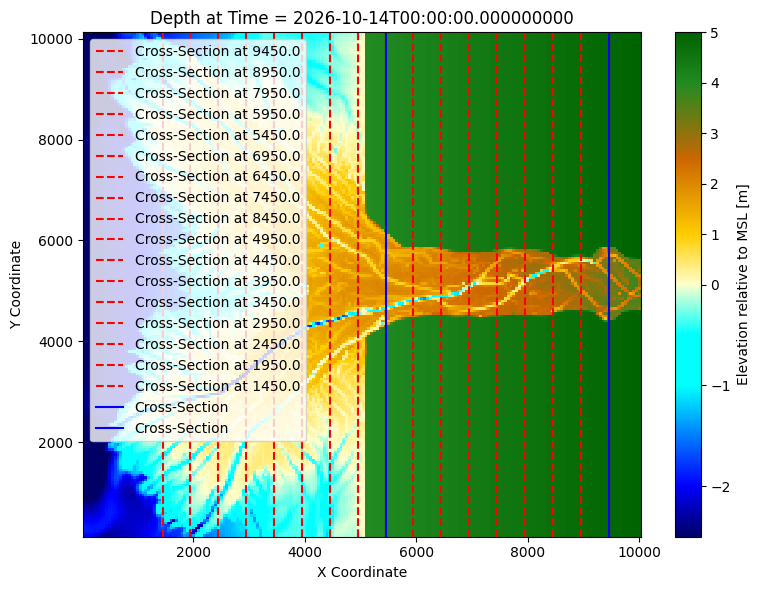

In [12]:
nc_file = trim500
time_index=-1
vmin=-2.5
vmax=5
vcenter=0

left_cross = 0
middle_cross = 4   # Indexes for the rivers

# Load the NetCDF file
dataset = xr.open_dataset(nc_file)

# Extract coordinates and depth data
xc = dataset["XCOR"].values
yc = dataset["YCOR"].values
depth = dataset["DPS"]

# Trim the edges
xc_inner = xc[1:-1, 1:-1]
yc_inner = yc[1:-1, 1:-1]
depth_inner = depth[:, 1:-1, 1:-1] * -1  # Flip sign for elevation

# Time values
time_values = dataset["time"].values
depth_at_t = depth_inner[time_index, :, :]

# Define sharp sea-level-transition colormap
colors = [
    (0.00, "#000066"),   # deep water
    (0.10, "#0000ff"),   # blue
    (0.30, "#00ffff"),   # cyan
    (0.40, "#00ffff"),  # water edge
    (0.50, "#ffffcc"),  # land edge
    (0.60, "#ffcc00"),   # orange
    (0.75, "#cc6600"),   # brown
    (0.90, "#228B22"),   # green
    (1.00, "#006400"),   # dark green
]
terrain_like = LinearSegmentedColormap.from_list("custom_terrain", colors)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# Open Trih files
ds_his = xr.open_mfdataset(trih500, preprocess=dfmt.preprocess_hisnc, decode_timedelta=True)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(xc_inner, yc_inner, depth_at_t, shading='auto', cmap=terrain_like, norm=norm)
for i in range(17):
    ax.axvline(ds_his.XYTRA[i].values[0], color='r', linestyle='--', label=f'Cross-Section at {ds_his.XYTRA[i].values[0]}')


# rando = 9
ax.axvline(ds_his.XYTRA[left_cross].values[0], color='b', linestyle='-', label=f'Cross-Section')
ax.axvline(ds_his.XYTRA[middle_cross].values[0], color='b', linestyle='-', label=f'Cross-Section')
# ax.axvline(ds_his.XYTRA[rando].values[0], color='y', linestyle='-', label=f'Cross-Section')

ax.set_title(f'Depth at Time = {time_values[time_index]}')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

cb = fig.colorbar(c, ax=ax, orientation='vertical', label='Elevation relative to MSL [m]')
plt.legend()
plt.tight_layout()
plt.show()

dataset.close()

Your model was run with a D-FlowFM version from before 28-10-2020 (FLOW2D3D Version 6.02.08.000000 from Nov 20 2016), the layers in the hisfile are incorrect. Check UNST-2920 and UNST-3024 for more information, it was fixed from OSS 67858.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


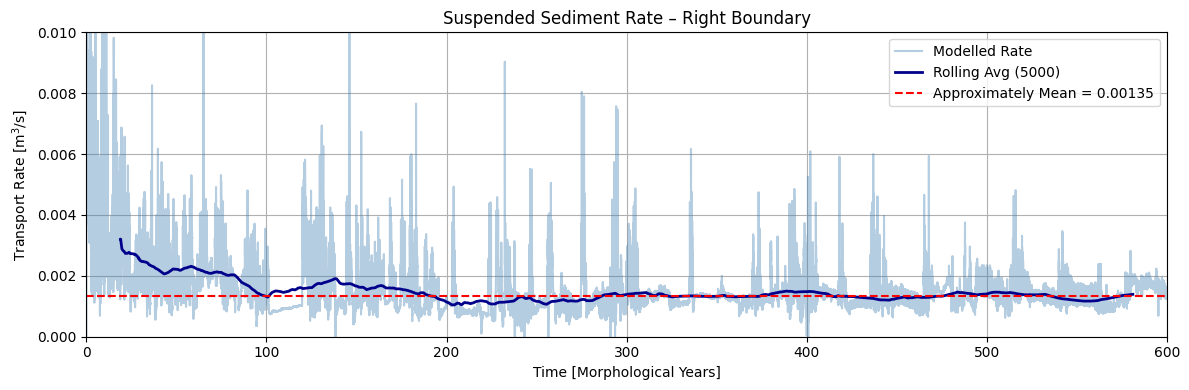

In [13]:
import numpy as np
import matplotlib.pyplot as plt

morfac = 400  # Morphological acceleration factor

# Assuming ds_his.time.values are in model days (numeric or datetime64)
# If datetime64, first convert to numeric time in days relative to start:

if np.issubdtype(ds_his.time.dtype, np.datetime64):
    # Convert datetime64 to elapsed model days
    elapsed_model_days = (ds_his.time.values - ds_his.time.values[0]) / np.timedelta64(1, 'D')
else:
    # If already numeric model days
    elapsed_model_days = ds_his.time.values - ds_his.time.values[0]

# Convert to real days using morph factor
elapsed_real_days = elapsed_model_days * morfac

# Convert to real years
time_years = elapsed_real_days / 365.25

rol_ave = 5000

fig, ax = plt.subplots(figsize=(12, 4))

bedload_left = ds_his.SBTR[:, 0, left_cross]*-1
mean_left = Calculate_Q(trih500, boundary=left_cross)
bedload_left_rolling = bedload_left.rolling(time=rol_ave, center=True).mean()

# Plot with explicit x = time_years
ax.plot(time_years, bedload_left.values, label='Modelled Rate', alpha=0.4, color='steelblue')
ax.plot(time_years, bedload_left_rolling.values, label=f'Rolling Avg ({rol_ave})', color='darkblue', linewidth=2)

# ax.axhline(y=mean_left, color='orange', linestyle=':', linewidth=1.5, label=f'Calculated Mean = {-1*mean_left:.5f}')
ax.axhline(y=0.00135, color='red', linestyle='--', linewidth=1.5, label='Approximately Mean = 0.00135')

ax.set_ylim(0, 0.01)
ax.set_xlim(0, 600)  # Limit x-axis to 600 years
ax.set_xlabel('Time [Morphological Years]')
ax.set_ylabel(r'Transport Rate [m$^3$/s]')
ax.set_title('Suspended Sediment Rate – Right Boundary')
ax.legend()
ax.grid(True)

plt.tight_layout()
# plt.savefig('C:/Users/camup/Documents/aaMEE/Master thesis/figures/BedLoadTransport.png')

plt.show()


## Sediment Transport Analysis 

Based on these graphs the sediment concentration, has largely stabalised, however, It does seem to behave in a random pattern. The Sediment concentration based on these graphs is. The value is positive cause the negative sign only illustrated direction. 

The estimated mean sediment transport rate (**Qs**) estimated from the stabilized portion of the time series is:

- **Qs = 0.00135 m³/s**

- NOTE: THIS IS THE VOLUME OF SAND WITHOUT PORE SPACE_ AS INPUT WE USE WITH PORE SPACE SO CONVERT it

This sediment transport rate will be used in subsequent **dredging applications** to inform volume estimates and operational planning.


In [15]:
###### Calc sediment rate per morhpological year. Including pore space:
qs = -0.00135  # m³/s (solid volume)
drate = qs * 3600 * 24 * 365 * -1# yearly volume in m³/year
print(f'Sediment rate per hydrological year is {drate:.2f} m³/y')

mrate = drate / 400  # morphological time
print(f'Sediment rate per morph year: {mrate:.2f} m³/y')

# Convert to bulk volume (including pores)
spec_dens = 2650
dry_dens = 1600
porosity = 1 - ( dry_dens / spec_dens)
print(f'The used porosity factor is {porosity:.2f} [-].' )

mrate_bulk = mrate / (1 - porosity) 
print(f'Sediment rate per morph year (including pores): {mrate_bulk:.2f} m³/y')

no_pits = 4
pit_rate = mrate_bulk / no_pits
print(f'Sediment rate per pit will be {pit_rate:.2f} m3/y in order to take up 100% as to what is taken in.')

Sediment rate per hydrological year is 42573.60 m³/y
Sediment rate per morph year: 106.43 m³/y
The used porosity factor is 0.40 [-].
Sediment rate per morph year (including pores): 176.28 m³/y
Sediment rate per pit will be 44.07 m3/y in order to take up 100% as to what is taken in.
